In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, multilabel_confusion_matrix

sns.set()   # Set the style for graphs
warnings.filterwarnings('ignore')   # Ignore all warnings

%matplotlib inline

In [2]:
# Comment the following lines if working on a white background
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

## Useful Functions

In [3]:
# Function to see detailed summary of continous variables
def cont_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                      x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                      x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                     index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [4]:
# Helper function to calculate ROC-AUC score using
# one-vs-all method for each class and the average score
def multiclass_roc_auc_score(actual_class, pred_class, average="macro"):
    unique_class = set(actual_class)
    roc_auc_dict = {}
    auc_sum = 0

    for per_class in unique_class: 
        other_class = [x for x in unique_class if x != per_class]

        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average=average).round(3)
        roc_auc_dict[per_class] = roc_auc
        auc_sum += roc_auc
      
    roc_auc_dict['avg'] = auc_sum / len(unique_class)

    return roc_auc_dict

## Data Loading & Inspection

**Context**

This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to
this date. The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4.

---



**Content**

Attribute Information:

1. age
2. sex (0 - female, 1 - male)
3. chest pain type (4 values)
4. resting blood pressure
5. serum cholestoral in mg/dl
6. fasting blood sugar > 120 mg/dl
7. resting electrocardiographic results (values 0,1,2)
8. maximum heart rate achieved
9. exercise induced angina
10. oldpeak = ST depression induced by exercise relative to rest
11. the slope of the peak exercise ST segment
12. number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
14. target variable (0 - 4, we will be treating as severity of heart disease)

In [5]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
data = pd.read_csv(url, header=None)

In [6]:
# data.columns = ['age', 'sex', 'chestpain', 'restbps', 'chol', 'fbs', 'restecg', 
#                 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
data.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','target']

In [7]:
data = data[data.ca != '?']
data.ca = data.ca.apply(float)
data = data[data.thal != '?']
data.thal = data.thal.apply(float)

In [8]:
data.shape

(297, 14)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    float64
 1   sex       297 non-null    float64
 2   cp        297 non-null    float64
 3   trestbps  297 non-null    float64
 4   chol      297 non-null    float64
 5   fbs       297 non-null    float64
 6   restecg   297 non-null    float64
 7   thalach   297 non-null    float64
 8   exang     297 non-null    float64
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    float64
 11  ca        297 non-null    float64
 12  thal      297 non-null    float64
 13  target    297 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 34.8 KB


In [10]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [11]:
data[data['target']==4].head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
24,60.0,1.0,4.0,130.0,206.0,0.0,2.0,132.0,1.0,2.4,2.0,2.0,7.0,4
40,65.0,0.0,4.0,150.0,225.0,0.0,2.0,114.0,0.0,1.0,2.0,3.0,7.0,4
45,58.0,1.0,3.0,112.0,230.0,0.0,2.0,165.0,0.0,2.5,2.0,1.0,7.0,4
47,50.0,1.0,4.0,150.0,243.0,0.0,2.0,128.0,0.0,2.6,2.0,0.0,7.0,4
121,63.0,0.0,4.0,150.0,407.0,0.0,2.0,154.0,0.0,4.0,2.0,3.0,7.0,4


In [12]:
data.describe().T   # 'T' is for transpose

,count,mean,std,min,25%,50%,75%,max
age,297.0,54.542088,9.049736,29.0,48.0,56.0,61.0,77.0
sex,297.0,0.676768,0.468500,0.0,0.0,1.0,1.0,1.0
cp,297.0,3.158249,0.964859,1.0,3.0,3.0,4.0,4.0
trestbps,297.0,131.693603,17.762806,94.0,120.0,130.0,140.0,200.0
chol,297.0,247.350168,51.997583,126.0,211.0,243.0,276.0,564.0
fbs,297.0,0.144781,0.352474,0.0,0.0,0.0,0.0,1.0
restecg,297.0,0.996633,0.994914,0.0,0.0,1.0,2.0,2.0
thalach,297.0,149.599327,22.941562,71.0,133.0,153.0,166.0,202.0
exang,297.0,0.326599,0.469761,0.0,0.0,0.0,1.0,1.0
oldpeak,297.0,1.055556,1.166123,0.0,0.0,0.8,1.6,6.2


In [13]:
# More detailed summary for continous variables
# 'select_dtypes' is used to select the columns of a particular datatype in the data
# 'apply' applies a function along an axis (row-wise or column-wise, default is column) of the data
data.select_dtypes(['int64', 'float64']).apply(cont_summary).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,297.0,0.0,16199.0,54.542088,56.0,9.049736,81.897716,29.0,34.96,40.0,42.0,48.0,56.0,61.0,66.0,68.0,71.120,77.0
sex,297.0,0.0,201.0,0.676768,1.0,0.468500,0.219492,0.0,0.00,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.000,1.0
cp,297.0,0.0,938.0,3.158249,3.0,0.964859,0.930954,1.0,1.00,1.0,2.0,3.0,3.0,4.0,4.0,4.0,4.000,4.0
trestbps,297.0,0.0,39113.0,131.693603,130.0,17.762806,315.517290,94.0,100.00,108.0,110.0,120.0,130.0,140.0,152.8,160.8,180.000,200.0
chol,297.0,0.0,73463.0,247.350168,243.0,51.997583,2703.748589,126.0,148.68,175.8,190.4,211.0,243.0,276.0,309.0,327.6,407.080,564.0
fbs,297.0,0.0,43.0,0.144781,0.0,0.352474,0.124238,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.000,1.0
restecg,297.0,0.0,296.0,0.996633,1.0,0.994914,0.989853,0.0,0.00,0.0,0.0,0.0,1.0,2.0,2.0,2.0,2.000,2.0
thalach,297.0,0.0,44431.0,149.599327,153.0,22.941562,526.315270,71.0,94.80,108.0,116.0,133.0,153.0,166.0,177.4,182.0,192.080,202.0
exang,297.0,0.0,97.0,0.326599,0.0,0.469761,0.220675,0.0,0.00,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000,1.0
oldpeak,297.0,0.0,313.5,1.055556,0.8,1.166123,1.359842,0.0,0.00,0.0,0.0,0.0,0.8,1.6,2.8,3.4,4.208,6.2


## Exploratory data Analysis

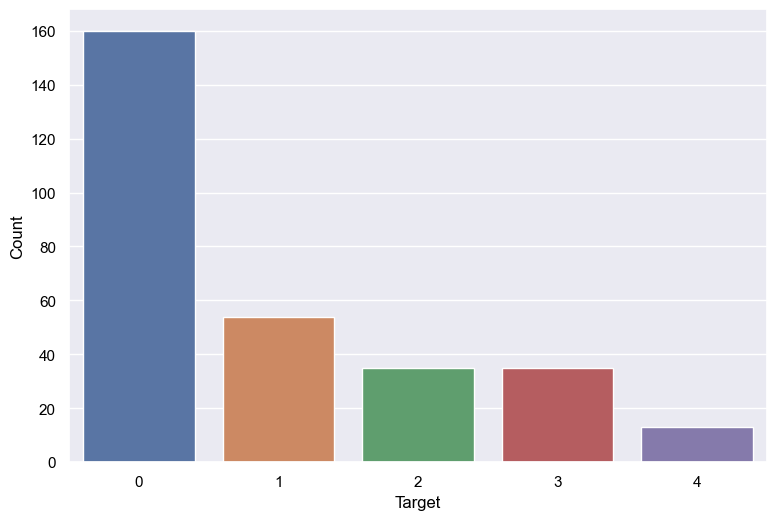

In [14]:
plt.figure(figsize=(9, 6), dpi=100)
sns.barplot(data.target.value_counts().index, data.target.value_counts())
plt.ylabel('Count')
plt.xlabel('Target')
plt.show()

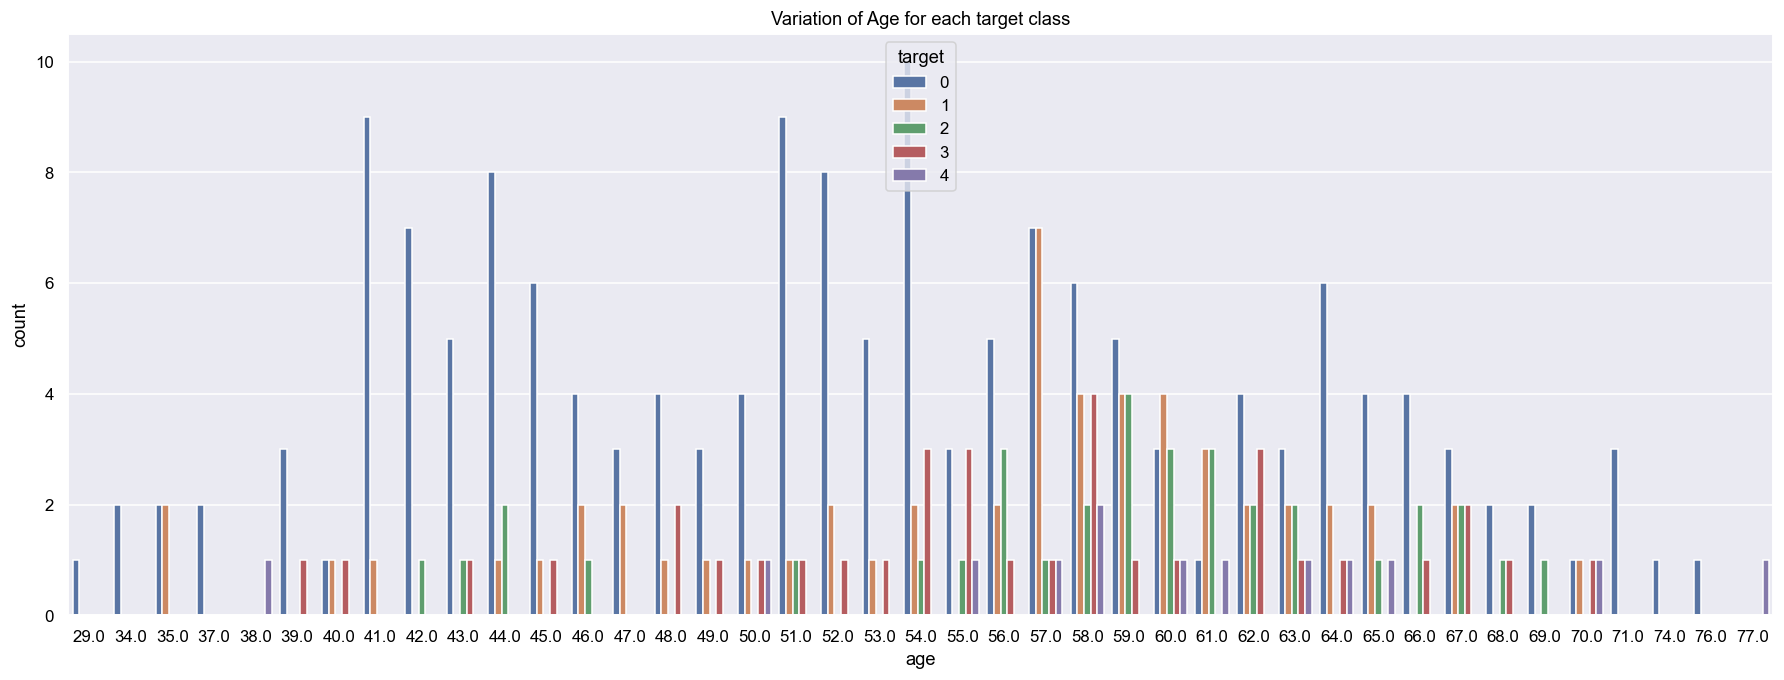

In [15]:
plt.figure(figsize=(20, 7), dpi=110)
sns.countplot(data=data, x='age', hue='target', order=data['age'].sort_values().unique())
plt.title('Variation of Age for each target class')
plt.show()

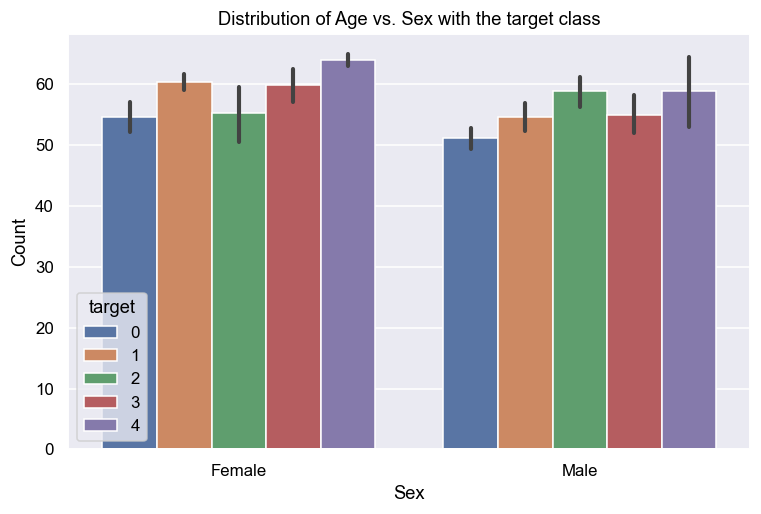

In [16]:
plt.figure(figsize=(8, 5), dpi=110)
graph = sns.barplot(data=data, x='sex', y='age', hue='target')
graph.set_xticklabels(['Female', 'Male'])
plt.title('Distribution of Age vs. Sex with the target class')
plt.ylabel('Count')
plt.xlabel('Sex')
plt.show()

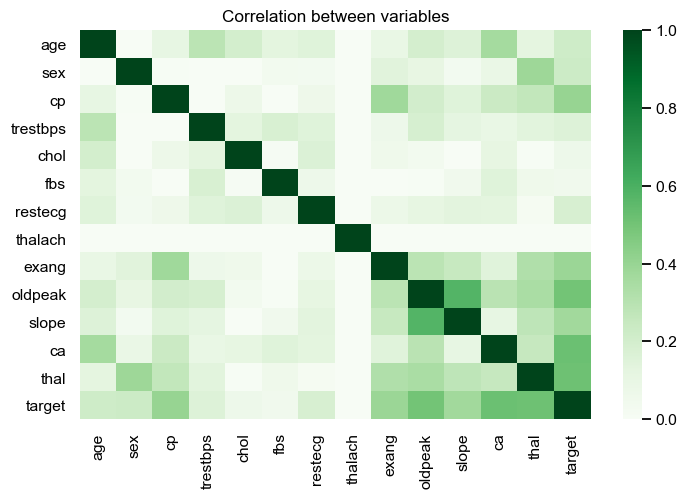

In [17]:
plt.figure(figsize=(8, 5), dpi=103)
plt.title('Correlation between variables')
sns.heatmap(data.corr(), cmap="Greens", vmin = 0, vmax=1)
plt.show()

In [18]:
# Export the correlations data to an excel file
data.corr().to_excel('Correlations_Heart_Disease.xlsx')

## Data Cleaning & Pre-processing

In [19]:
# Create a copy of the data before pre-processing
df = data.copy()

In [20]:
# Since we have total missing values less than 5% of the size of dataset, we will drop them
df.dropna(inplace=True)

In [21]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [22]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [23]:
ros = RandomOverSampler(random_state=99)
X, y = ros.fit_resample(df.drop(['target'], axis=1), df.target)

In [24]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


In [25]:
y.head()

0    0
1    2
2    1
3    0
4    0
Name: target, dtype: int64

In [26]:
len(X), len(y)

(800, 800)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
len(X_train), len(X_test), len(y_train), len(y_test)

(640, 160, 640, 160)

## Modelling

#### Logistic Regression

In [29]:
logreg = LogisticRegression(random_state=17)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=17)

In [30]:
y_hat = logreg.predict(X_test)

In [31]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.62      0.77      0.69        30
           1       0.50      0.31      0.38        36
           2       0.40      0.48      0.44        25
           3       0.29      0.24      0.26        33
           4       0.49      0.58      0.53        36

    accuracy                           0.47       160
   macro avg       0.46      0.48      0.46       160
weighted avg       0.46      0.47      0.46       160



In [32]:
print('Train Accuracy:', accuracy_score(y_train, logreg.predict(X_train)).round(4) * 100)
print('Test Accuracy:', accuracy_score(y_test, y_hat).round(4) * 100)

Train Accuracy: 47.660000000000004
Test Accuracy: 46.88


In [33]:
print('Train ROC-AUC:', multiclass_roc_auc_score(y_train, logreg.predict(X_train)))
print('Test ROC-AUC:', multiclass_roc_auc_score(y_test, y_hat))

Train ROC-AUC: {0: 0.808, 1: 0.635, 2: 0.612, 3: 0.599, 4: 0.711, 'avg': 0.6729999999999999}
Test ROC-AUC: {0: 0.829, 1: 0.608, 2: 0.673, 3: 0.542, 4: 0.703, 'avg': 0.671}


In [34]:
cv_logreg = cross_val_score(logreg, X_test, y_test, cv=10).mean().round(4) * 100
print(cv_logreg)

43.120000000000005


In [35]:
multilabel_confusion_matrix(y_test, y_hat)

array([[[116,  14],
        [  7,  23]],

       [[113,  11],
        [ 25,  11]],

       [[117,  18],
        [ 13,  12]],

       [[107,  20],
        [ 25,   8]],

       [[102,  22],
        [ 15,  21]]], dtype=int64)

#### SVM

In [36]:
svm = SVC(random_state=75)
svm.fit(X_train, y_train)

SVC(random_state=75)

In [37]:
y_hat = svm.predict(X_test)

In [38]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.33      0.60      0.43        30
           1       0.24      0.28      0.26        36
           2       0.20      0.44      0.28        25
           3       0.33      0.03      0.06        33
           4       0.57      0.11      0.19        36

    accuracy                           0.28       160
   macro avg       0.34      0.29      0.24       160
weighted avg       0.35      0.28      0.23       160



In [39]:
print('Train Accuracy:', accuracy_score(y_train, svm.predict(X_train)).round(4) * 100)
print('Test Accuracy:', accuracy_score(y_test, y_hat).round(4) * 100)

Train Accuracy: 29.53
Test Accuracy: 27.500000000000004


In [40]:
print('Train ROC-AUC:', multiclass_roc_auc_score(y_train, svm.predict(X_train)))
print('Test ROC-AUC:', multiclass_roc_auc_score(y_test, y_hat))

Train ROC-AUC: {0: 0.711, 1: 0.502, 2: 0.512, 3: 0.524, 4: 0.539, 'avg': 0.5576000000000001}
Test ROC-AUC: {0: 0.662, 1: 0.51, 2: 0.561, 3: 0.507, 4: 0.543, 'avg': 0.5566000000000001}


In [41]:
cv_svm = cross_val_score(svm, X_test, y_test, cv=10).mean().round(4) * 100
print(cv_svm)

24.38


In [42]:
multilabel_confusion_matrix(y_test, y_hat)

array([[[ 94,  36],
        [ 12,  18]],

       [[ 92,  32],
        [ 26,  10]],

       [[ 92,  43],
        [ 14,  11]],

       [[125,   2],
        [ 32,   1]],

       [[121,   3],
        [ 32,   4]]], dtype=int64)

#### Random Forest

In [43]:
rfc = RandomForestClassifier(random_state=58)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=58)

In [44]:
y_hat = rfc.predict(X_test)

In [45]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91        30
           1       0.94      0.92      0.93        36
           2       0.89      1.00      0.94        25
           3       0.97      1.00      0.99        33
           4       1.00      1.00      1.00        36

    accuracy                           0.96       160
   macro avg       0.95      0.96      0.95       160
weighted avg       0.96      0.96      0.96       160



In [46]:
print('Train Accuracy:', accuracy_score(y_train, rfc.predict(X_train)).round(4) * 100)
print('Test Accuracy:', accuracy_score(y_test, y_hat).round(4) * 100)

Train Accuracy: 100.0
Test Accuracy: 95.62


In [47]:
# save the model to disk
import joblib
filename = 'heart_disease_prediction_using_random_forest_classifier_model.sav'
joblib.dump(rfc, filename)

['heart_disease_prediction_using_random_forest_classifier_model.sav']

In [48]:
# some time later...

# load the model from disk
heart_model = joblib.load(filename)

In [49]:
print('Train ROC-AUC:', multiclass_roc_auc_score(y_train, rfc.predict(X_train)))
print('Test ROC-AUC:', multiclass_roc_auc_score(y_test, y_hat))

Train ROC-AUC: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 'avg': 1.0}
Test ROC-AUC: {0: 0.929, 1: 0.95, 2: 0.989, 3: 0.996, 4: 1.0, 'avg': 0.9728}


In [50]:
cv_rfc = cross_val_score(rfc, X_test, y_test, cv=10).mean().round(4) * 100
print(cv_rfc)

68.75


In [51]:
multilabel_confusion_matrix(y_test, y_hat)

array([[[129,   1],
        [  4,  26]],

       [[122,   2],
        [  3,  33]],

       [[132,   3],
        [  0,  25]],

       [[126,   1],
        [  0,  33]],

       [[124,   0],
        [  0,  36]]], dtype=int64)

#### Comparison 

In [52]:
# Comparing the results obtained from different models with default parameters
df_compare = pd.DataFrame({'Model': [type(logreg).__name__, type(svm).__name__, type(rfc).__name__],
                           'Train_Accuracy': [logreg.score(X_train, y_train).round(4) * 100, 
                                              svm.score(X_train, y_train).round(4) * 100, rfc.score(X_train, y_train).round(4) * 100],
                           'Test_Accuracy': [logreg.score(X_test, y_test).round(4) * 100, 
                                              svm.score(X_test, y_test).round(4) * 100, rfc.score(X_test, y_test).round(4) * 100],
                           'Train_ROC-AUC': [multiclass_roc_auc_score(y_train, logreg.predict(X_train))['avg'].round(4) * 100,
                                             multiclass_roc_auc_score(y_train, svm.predict(X_train))['avg'].round(4) * 100,
                                             multiclass_roc_auc_score(y_train, rfc.predict(X_train))['avg'].round(4) * 100],
                           'Test_ROC-AUC': [multiclass_roc_auc_score(y_test, logreg.predict(X_test))['avg'].round(4) * 100,
                                             multiclass_roc_auc_score(y_test, svm.predict(X_test))['avg'].round(4) * 100,
                                             multiclass_roc_auc_score(y_test, rfc.predict(X_test))['avg'].round(4) * 100],
                           'Cross_Validation': [cv_logreg, cv_svm, cv_rfc]})

In [53]:
df_compare

,Model,Train_Accuracy,Test_Accuracy,Train_ROC-AUC,Test_ROC-AUC,Cross_Validation
0,LogisticRegression,47.66,46.88,67.30,67.10,43.12
1,SVC,29.53,27.50,55.76,55.66,24.38
2,RandomForestClassifier,100.00,95.62,100.00,97.28,68.75
